# desc-wfmon/perfstat.ipynb

Version 1.02  

Generate and verify the perfstat table used in DESC gen3_workflow.  

We assume [desc-wfmon](https://github.com/LSSTDESC/desc-wfmon) has been installed using the install notebook.


In [1]:
import os
print(f"Working directory is {os.getcwd()}")

Working directory is /global/u2/d/dladams/desc/rundirs/ptest17


In [2]:
# Set up desc-wfmon, installing if needed in the local directory.
insfile = 'install/setup.py'
doinstall = not os.path.exists(insfile)
if doinstall or True:
    import os
    devdir = f"{os.getenv('HOME')}/desc/dev"
    pkgdir = f"{devdir}/desc-wfmon"
    bsfil = f"{pkgdir}/bootstrap.py"
    if not os.path.exists(bsfil):
        print(f"ERROR: Unable to find desc-wfmon bootstrap: {bsfil}")
    # Run boostrap that build and install in ./install.
    %run $bsfil
%run {insfile}

import sys
import collections
import pandas
import desc.wfmon
import desc.sysmon
import matplotlib.pyplot as plt

print(f"Python version is {sys.version}")
for pkg in [desc.wfmon, desc.sysmon]:
    print(f"{pkg} version is {pkg.__version__}")

bootstrap: Installing descr-wfmon.
Installing /global/homes/d/dladams/desc/dev/desc-wfmon at ./install/noconda
Processing /global/homes/d/dladams/desc/dev/desc-wfmon


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for desc-wfmon: filename=desc_wfmon-0.3.0-py3-none-any.whl size=34254 sha256=ee65a7ed33a1b7a4f9f4bf911b71ad01774a70e820875f4c86e969837dfe55fa
  Stored in directory: /global/u2/d/dladams/.cache/pip/wheels/8c/c4/a7/e0f7d35d0abda943febbfb967d473d73927ae1840007e59d62
Successfully built desc-wfmon
bootstrap: Package desc-wfmon is installed at ./install/noconda
Done
TestMonDbReader:ctor: Done.
Python version is 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
<module 'desc.wfmon' from '/global/u2/d/dladams/desc/rundirs/ptest17/./install/noconda/desc/wfmon/__init__.py'> version is 0.3.0
<module 'desc.sysmon' from '/global/u2/d/dladams/desc/rundirs/ptest17/./install/no

## Configuration
List the system and process monitoring files for which we want schema.

In [3]:
# List of files to display
sysfils = ['sysmon.csv']
prcfils = ['runinfo/monitoring.db']

# Set the level for process tables.
lev = 2

# Set units for the memory.
bunit, sbuinit = 1, 'byte'
#bunit, sbunit = 2**20, 'MB'
#bunit, sbunit = 2**30, 'GB'

## Fetch system-level monitoring schema.

In [4]:
line = '----------------------------------------------------------------------------'
print(line)
for sysfil in sysfils:
    if os.path.exists(sysfil):
        print(f"System monitor file: {sysfil}")
        sym = pandas.read_csv(sysfil)
        print(f"System monitor sample count: {len(sym)}")
        print(f"System monitor columns:")
        for cnam in sym.columns:
            print(f"  {cnam}")   
        assert(len(sym.cpu_count.unique()) == 1)
        ncpu = sym.cpu_count[0]
        print(f"CPU count is {ncpu:.0f}")
        assert(len(sym.mem_total.unique()) == 1)
        maxmem = sym.mem_total[0]
        print(f"Total memory is {maxmem:.1f} GB")
    else:
        print(f"File not found: {sysfil}")
    print(line)

----------------------------------------------------------------------------
System monitor file: sysmon.csv
System monitor sample count: 712
System monitor columns:
  time
  cpu_count
  cpu_percent
  cpu_freq
  cpu_user
  cpu_system
  cpu_idle
  cpu_iowait
  cpu_time
  mem_total
  mem_available
  mem_swapfree
  dio_readsize
  dio_writesize
  nio_readsize
  nio_writesize
CPU count is 128
Total memory is 251.3 GB
----------------------------------------------------------------------------


## Fetch the process-level monitoring schema

The process monitoring data is read from the mysql DB produced by parsl. Of particular interest is the task table where metrics are sampled at regular intervals seprately for each job.

In [5]:
print(line)
for prcfil in prcfils:
    if os.path.exists(prcfil):
        dbr = desc.wfmon.MonDbReader(prcfil, fix=False)
        dbr.tables(lev)
        print(dbr.table('task').query('task_id<10').task_stderr)
    else:
        print(f"File not found: {sysfil}")
    print(line)

----------------------------------------------------------------------------
DB runinfo/monitoring.db has 7 tables
*******************************************************
Table workflow has 1 rows and 10 columns
Column names:
    object   run_id
    object   workflow_name
    object   workflow_version
    object   time_began
    object   time_completed
    object   host
    object   user
    object   rundir
     int64   tasks_failed_count
     int64   tasks_completed_count
*******************************************************
Table task has 2159 rows and 15 columns
Column names:
     int64   task_id
    object   run_id
    object   task_depends
    object   task_func_name
    object   task_memoize
    object   task_hashsum
    object   task_inputs
    object   task_outputs
    object   task_stdin
    object   task_stdout
    object   task_stderr
    object   task_time_invoked
    object   task_time_returned
     int64   task_fail_count
   float64   task_fail_cost
********************

## Fetch the perf data.

In [6]:
pfm = desc.wfmon.PerfStatLogReader(0)
print(f"Reading perf stat data.")
ret = pfm.read_mondb_logs(dbr, 1)
print(f"nskip = {pfm.nskip} ?= {ret['nskip']}")
print(f"nkeep = {pfm.nkeep} ?= {ret['nkeep']}")
print(f"nfile = {pfm.nfile}")
print(f" nval = {pfm.nval}")
print(f"nmiss = {pfm.nmissing}")
print(f"Perf state names: {pfm.dict.keys()}")
assert(pfm.nkeep == ret["nkeep"])
#assert(pfm.nskip == ret["nskip"])
pft = pfm.table()
print(pft)
print(f"Run IDs: {dbr.run_ids}")
print(f"Task names: {dbr.task_names}")
print(f"Task counts: {dbr.task_name_counts}")

#print(pfm.dict)

Reading perf stat data.
PerfStatLogReader::read_mondb_logs: Fixing input task table.
PerfStatLogReader::read_mondb_logs: Fixing input times.
PerfStatLogReader::read_mondb_logs: nskip = 0
PerfStatLogReader::read_mondb_logs: nkeep = 2159
PerfStatLogReader::read_mondb_logs: nfile = 2159
PerfStatLogReader::read_mondb_logs:  nval = 2159
PerfStatLogReader::read_mondb_logs: nmiss = 0
PerfStatLogReader::read_mondb_logs: Perf state names: odict_keys(['run_idx', 'task_idx', 'task_id', 'tstart', 'tstop', 'task-clock:u', 'context-switches:u', 'cpu-migrations:u', 'page-faults:u', 'cycles:u', 'stalled-cycles-frontend:u', 'stalled-cycles-backend:u', 'instructions:u', 'branches:u', 'branch-misses:u', 'L1-dcache-loads:u', 'L1-dcache-load-misses:u', 'time-elapsed', 'user', 'sys'])
nskip = 0 ?= 0
nkeep = 2159 ?= 2159
nfile = 2159
 nval = 2159
nmiss = 0
Perf state names: odict_keys(['run_idx', 'task_idx', 'task_id', 'tstart', 'tstop', 'task-clock:u', 'context-switches:u', 'cpu-migrations:u', 'page-faults:

In [7]:
dbr.fix_times()
tsk = dbr.table('task')
ttr = dbr.table('try')
assert(len(tsk) == len(pft))
for nam in ['run_idx', 'task_idx', 'task_id']:
    dif = pft[nam] - tsk[nam]
    udif = dif.unique()
    print(f"Unique task diffs for {nam}: {udif}")
    ttrdif = pft[nam] - ttr[nam]
    uttrdif = ttrdif.unique()
    print(f"Unique  try diffs for {nam}: {uttrdif}")


Unique task diffs for run_idx: [0]
Unique  try diffs for run_idx: [0]
Unique task diffs for task_idx: [0]
Unique  try diffs for task_idx: [0]
Unique task diffs for task_id: [0]
Unique  try diffs for task_id: [0]


## Plot setup
Set plotting params and define functions to plot histograms and graphs.

In [8]:
sfx = '.png'
print(f"Plot file suffix: {sfx}")
plt.rc('font', size=16)
plt.rc('savefig', facecolor='white', bbox='tight')
plt.rc('axes', titlesize='medium')

def clip(x, x1, x2):
    x1c = 1.001*x1 if x1 > 0 else 0.999*x1
    x2c = 1.001*x2 if x2 < 0 else 0.999*x2
    return x.clip(x1c, x2c)

def hist(x, x1, x2, slab, slabx, slaby, sttl, fnam='', legpos='upper right'):
    xc = clip(x, x1, x2)
    count = len(xc)
    mean = xc.mean()
    slab_long = f"{slab} [{count}] {mean:0.2f}"
    plt.figure(figsize=(pdx, pdy))
    scol = 'tab:blue'
    if '180GB' in sttl: scol = 'tab:red'
    sav = plt.hist(bins=100, range=(x1, x2), x=xc, label=slab_long, color=scol)
    plt.legend(loc=legpos, fontsize=12)
    plt.xlabel(slabx)
    plt.ylabel(slaby)
    junk = plt.xlim([x1, x2])
    plt.title(sttl)
    if len(fnam):
        pfx = os.path.basename(os.getcwd()) + '-'
        sfx = '.png'
        pathout = pfx + fnam + sfx
        print(f"Saving plot to {pathout}")
        plt.savefig(pathout)
        
def graph(x, y, x1, x2, y1, y2, slab, slabx, slaby, sttl, fnam='', legpos='upper right'):
    yc = clip(y, y1, y2)
    count = len(y)
    mean = yc.mean()
    slab_long = f"{slab} [{count}] {mean:0.2f}"
    plt.figure(figsize=(pdx, pdy))
    scol = 'tab:blue'
    if '180GB' in sttl: scol = 'tab:red'
    sav = plt.plot(x, yc, '.', label=slab_long, color=scol)
    plt.legend(loc=legpos, fontsize=12)
    plt.xlabel(slabx)
    plt.ylabel(slaby)
    junkx = plt.xlim([x1, x2])
    junky = plt.ylim([y1, y2])
    plt.title(sttl)
    plt.grid(True)
    if len(fnam):
        pfx = os.path.basename(os.getcwd()) + '-'
        sfx = '.png'
        pathout = pfx + fnam + sfx
        print(f"Saving plot to {pathout}")
        plt.savefig(pathout)
        
def multigraph(xs, ys, x1, x2, y1, y2, slabs, slabx, slaby, sttl, fnam='', legpos='upper right', nlegcol=1):
    nplt = len(xs)
    assert( len(ys) == nplt )
    ycs = nplt*[None]
    mean = nplt*[]
    slab_longs = nplt*[None]
    for iplt in range(nplt):
        ycs[iplt] = clip(ys[iplt], y1, y2)
        mean = ycs[iplt].mean()
        count = len(ycs[iplt])
        slab_longs[iplt] = f"{slabs[iplt]} [{count}] {mean:0.2f}"
    plt.figure(figsize=(pdx, pdy))
    for iplt in range(nplt):
        sav = plt.plot(xs[iplt], ycs[iplt], '.', label=slab_longs[iplt], color=None)
    plt.legend(loc=legpos, fontsize=12, ncol=nlegcol)
    plt.xlabel(slabx)
    plt.ylabel(slaby)
    junkx = plt.xlim([x1, x2])
    junky = plt.ylim([y1, y2])
    plt.title(sttl)
    plt.grid(True)
    if len(fnam):
        pfx = os.path.basename(os.getcwd()) + '-'
        sfx = '.png'
        pathout = pfx + fnam + sfx
        print(f"Saving plot to {pathout}")
        plt.savefig(pathout)

Plot file suffix: .png


Plot title: 06apr2022-16:30: perlmutter-lsi-225GB sfp_Y1_4430_24, w_2022_10_dla05 dtproc=3s
Index(['task_id', 'run_idx', 'task_depends', 'task_idx', 'task_memoize',
       'task_hashsum', 'task_inputs', 'task_outputs', 'task_stdin',
       'task_stdout', 'task_stderr', 'task_time_invoked', 'task_time_returned',
       'task_fail_count', 'task_fail_cost'],
      dtype='object')
0.013564109802246094
tmean_max = 20.0 1.0
Saving plot to ptest17-tmean.png
Saving plot to ptest17-runtime.png


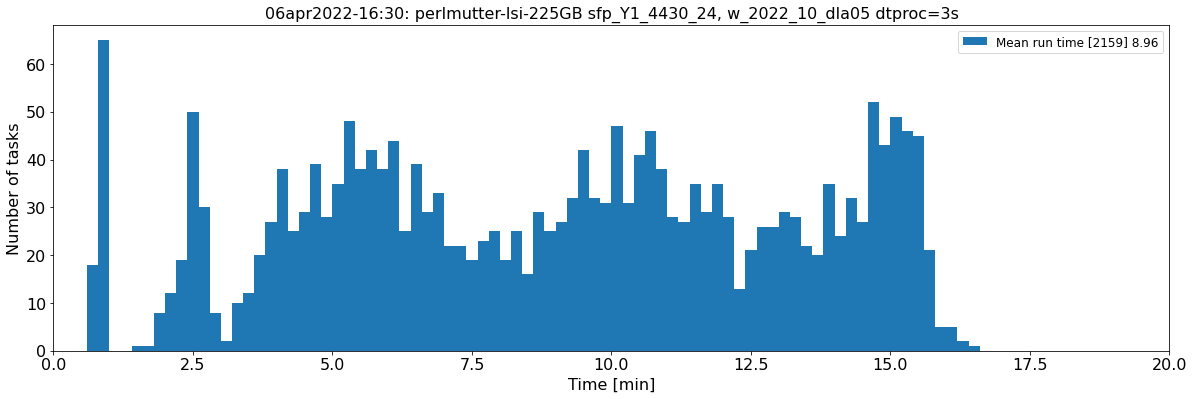

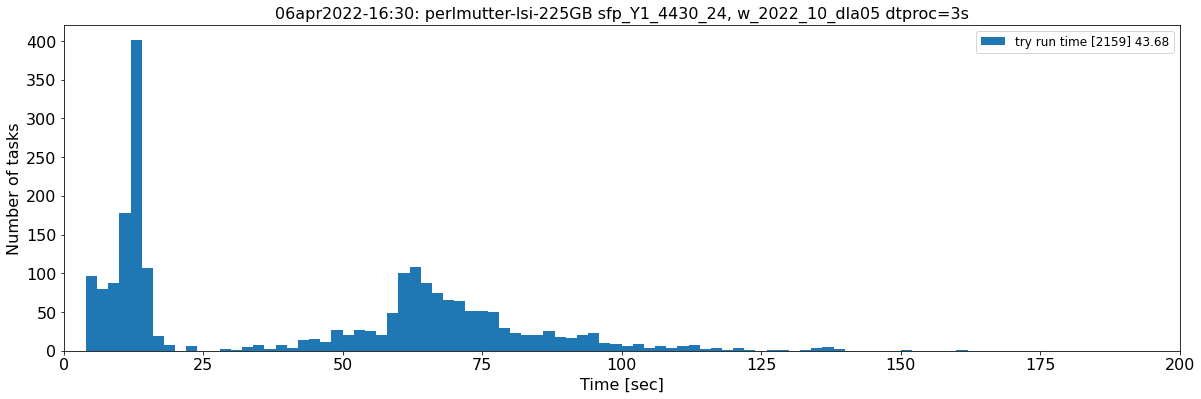

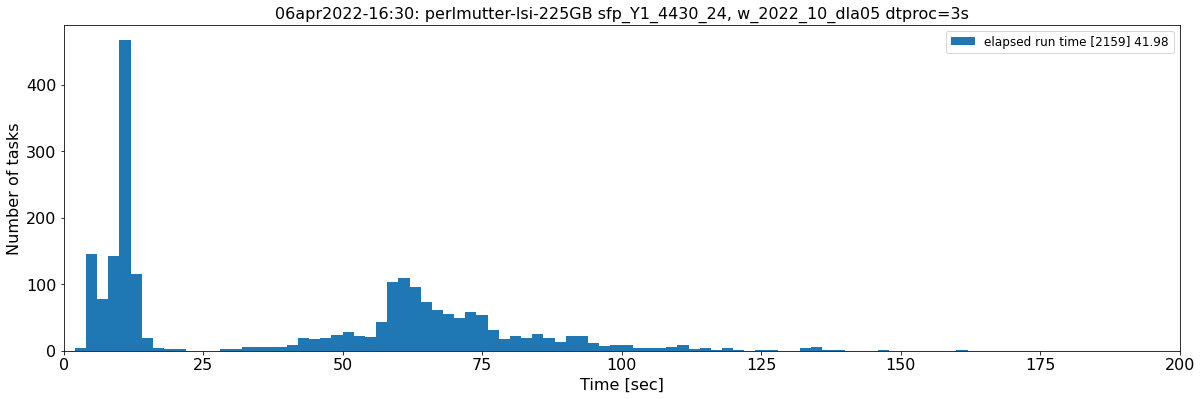

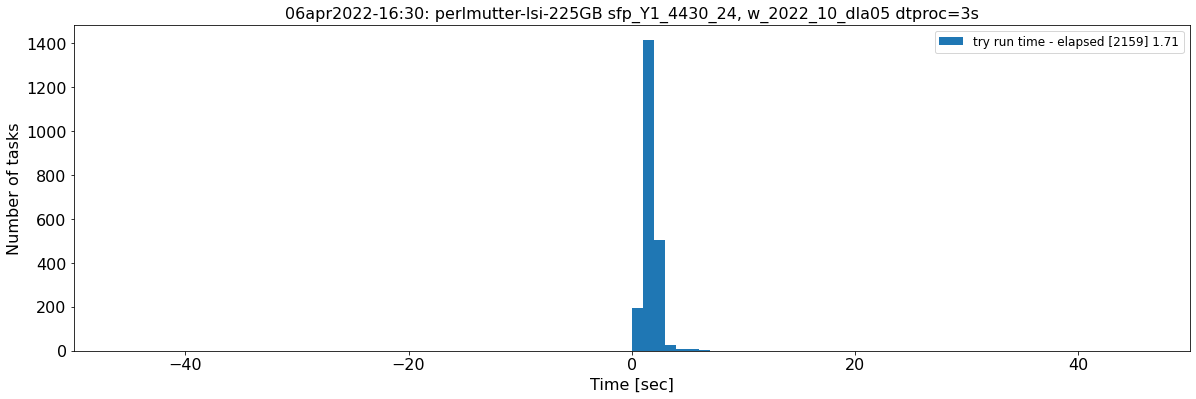

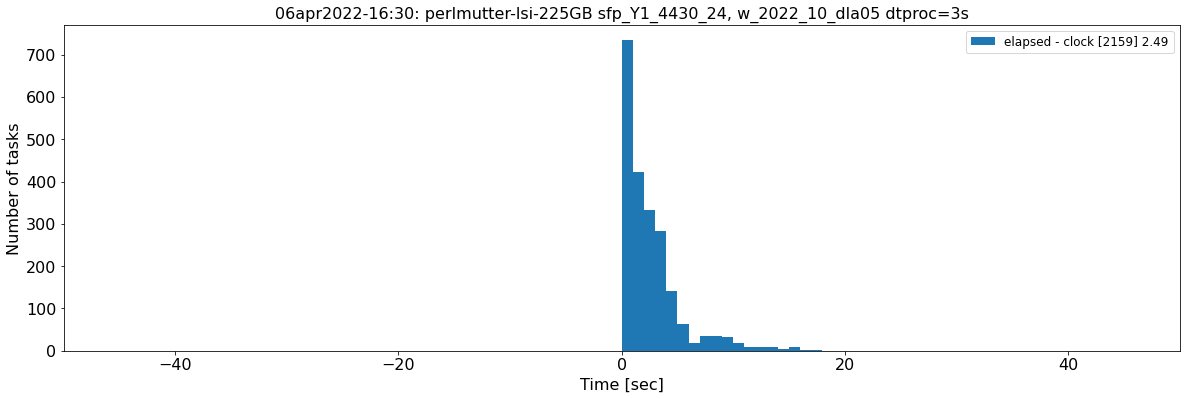

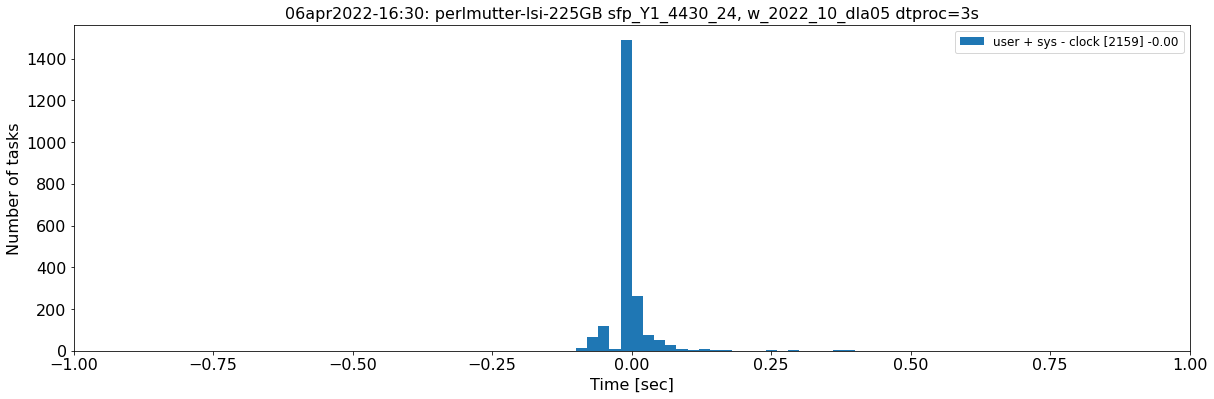

In [9]:
sttl = open('README.txt', 'r').readline().strip()
print(f"Plot title: {sttl}")
# Plot size
pdx = 20
pdy = 6

print(tsk.columns)
t0 = min(tsk.task_time_invoked)
print(t0)
tsk['tfix'] = tsk.task_time_invoked - t0
if sym is not None:
    sym['tfix'] = sym['time'] - dbr.t0 - t0
ttr_start = ttr.task_try_time_running
pft['tmean'] = 0.5*(pft.tstart + pft.tstop)/60
tmean_max = max((max(pft.tmean)//10 + 1)*10, 20)
print(f"tmean_max = {tmean_max} {max(pft.tmean)//10}")
pft['twall'] = pft.tstop - pft.tstart
pft['gins'] = 1.e-9*pft['instructions:u']
ttr_dt = ttr.task_try_time_returned - ttr.task_try_time_running
pft_dt = pft['time-elapsed']
pft_clk = pft['task-clock:u']*0.001    # usec --> sec
pft_usy = pft['user'] + pft['sys']

slabx = 'Time [sec]'
slaby = 'Number of tasks'
x1 = 0
x2 = 20
hist(pft.tmean, x1, x2, 'Mean run time', 'Time [min]', slaby, sttl, 'tmean')
x2 = 200
hist(ttr_dt, x1, x2, 'try run time', slabx, slaby, sttl, 'runtime')
hist(pft_dt, x1, x2, 'elapsed run time', slabx, slaby, sttl)

x1 = -50
x2 = 50
hist( ttr_dt-pft_dt, x1, x2, 'try run time - elapsed', slabx, slaby, sttl)
hist(pft_dt-pft_clk, x1, x2, 'elapsed - clock', slabx, slaby, sttl)
x1 = -1
x2 = 1
hist(pft_usy-pft_clk, x1, x2, 'user + sys - clock', slabx, slaby, sttl)

Saving plot to ptest17-insts.png


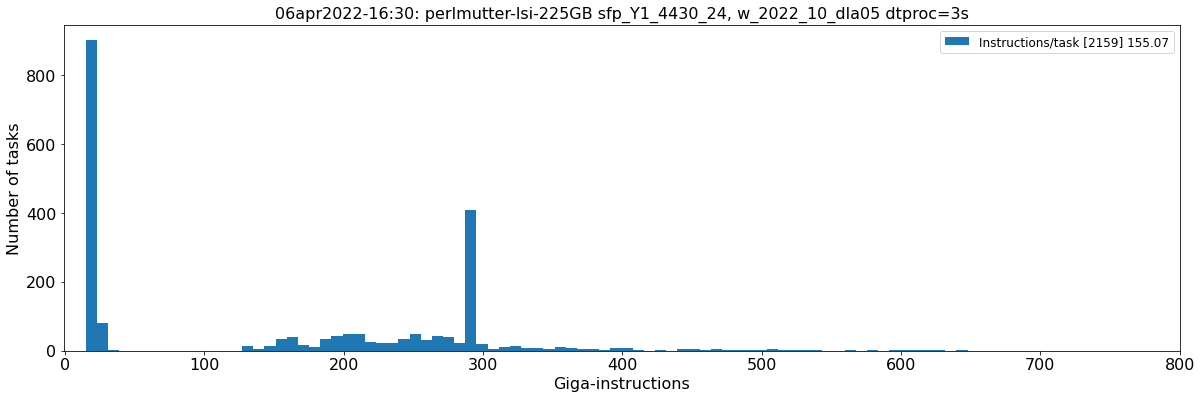

In [10]:
# Instructions
x2 = 800
hist(pft.gins, x1, x2, 'Instructions/task', 'Giga-instructions', slaby, sttl, 'insts')

Saving plot to ptest17-instructions.png
Saving plot to ptest17-cputeff.png
Saving plot to ptest17-cpuspeed.png
Saving plot to ptest17-ips.png
Saving plot to ptest17-insclockspeed.png
Saving plot to ptest17-inswallspeed.png


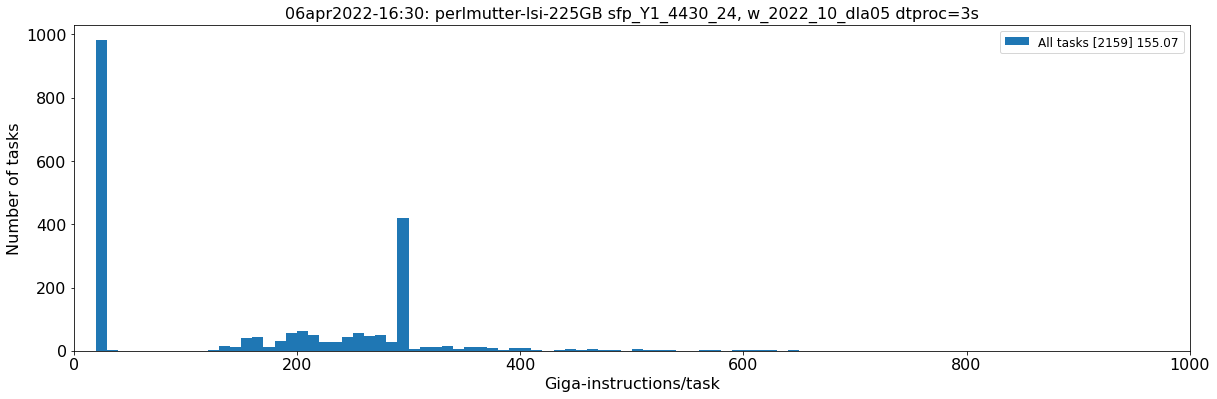

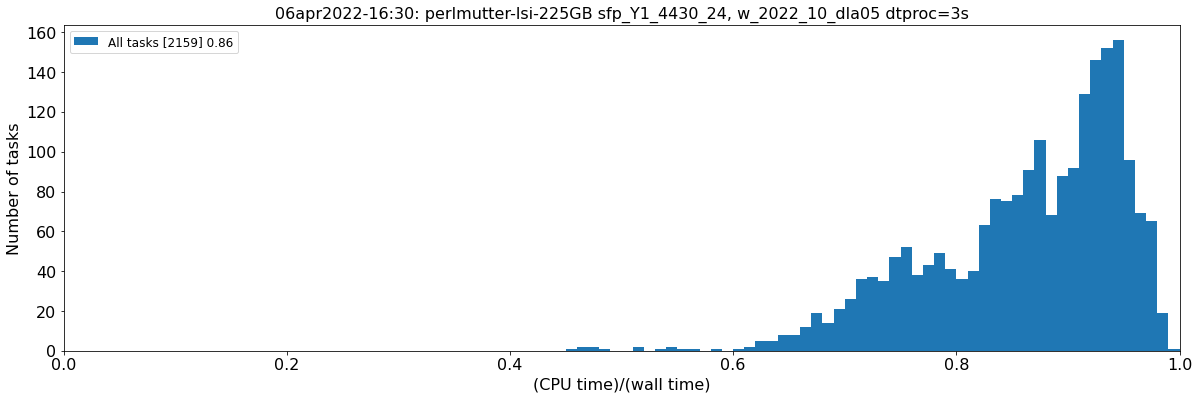

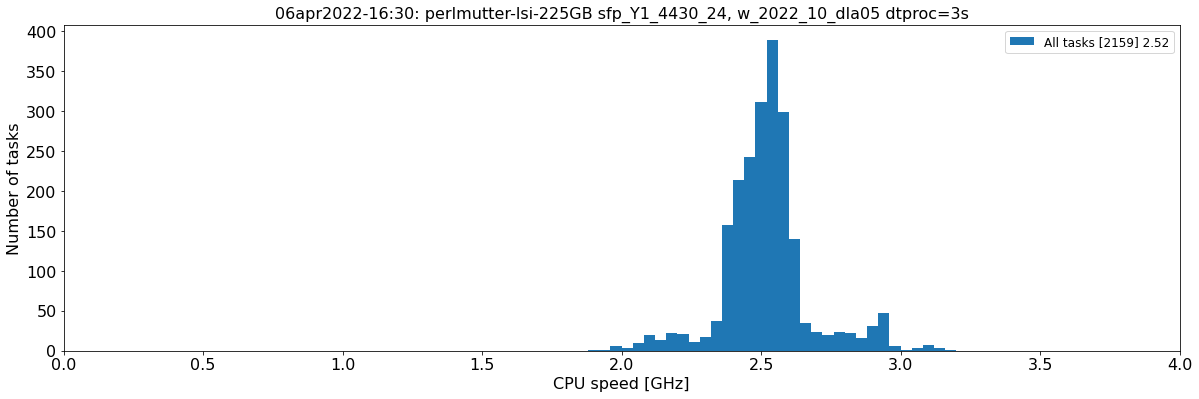

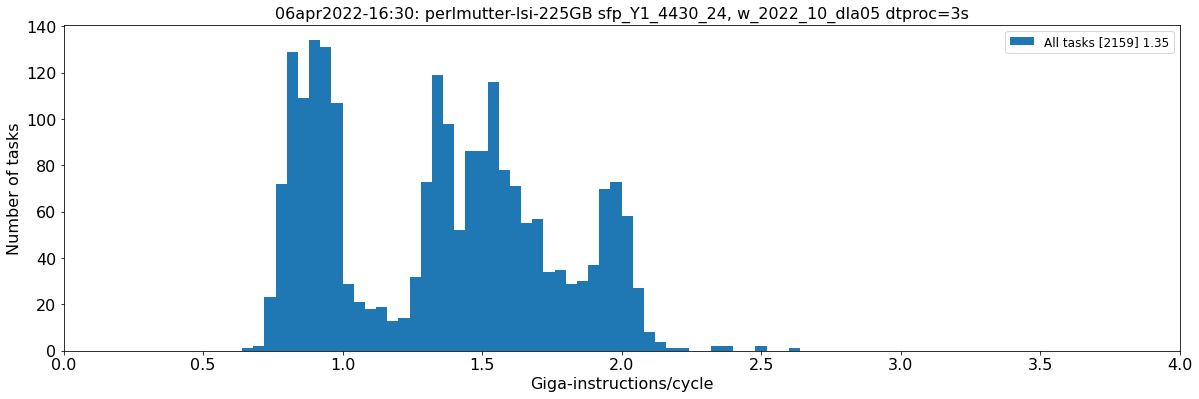

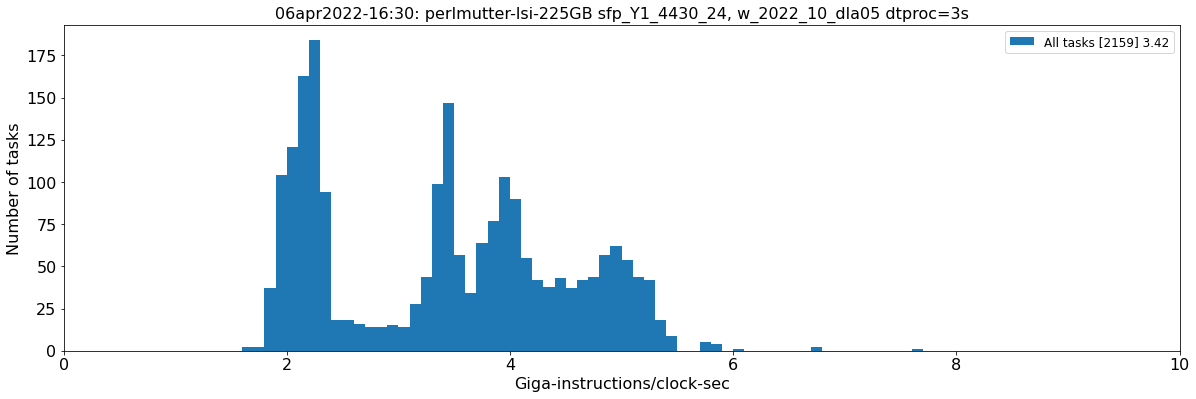

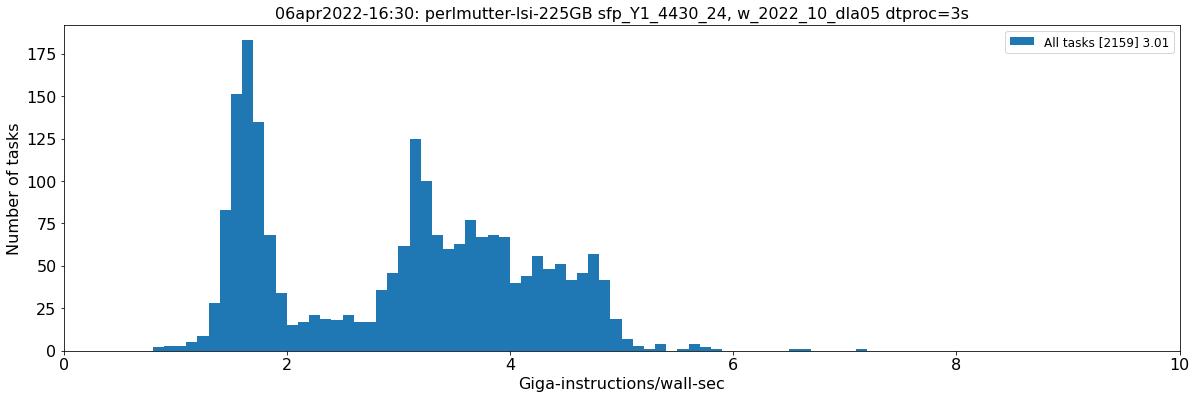

In [11]:
slab = 'All tasks'

# Instructions/task
x1 = 0
x2 = 1000
hist(pft.gins, x1, x2, slab, 'Giga-instructions/task', slaby, sttl, 'instructions', 'upper right')

# CPU time efficiency
pft['cputeff'] = pft_clk/pft['twall']
x1 = 0
x2 = 1.0
hist(pft.cputeff, x1, x2, slab, '(CPU time)/(wall time)', slaby, sttl, 'cputeff', 'upper left')

# CPU speed
speed = pft['cycles:u']/pft_clk*1.e-9    # /sec --> GHz
x1 = 0
x2 = 4
slabx = 'CPU speed [GHz]'
hist(speed, x1, x2, slab, 'CPU speed [GHz]', slaby, sttl, 'cpuspeed')

# Instructions per cycle
pft['ipc'] = pft['instructions:u']/pft['cycles:u']
hist(pft.ipc, x1, x2, slab, 'Giga-instructions/cycle', slaby, sttl, 'ips')

# Instruction clock speed.
x2 = 10
pft['ips'] = pft.gins/pft_clk
hist(pft.ips, x1, x2, 'All tasks', 'Giga-instructions/clock-sec', slaby, sttl, 'insclockspeed')

# Instruction wall speed.
x2 = 10
pft['ipw'] = pft.gins/pft.twall
hist(pft.ipw, x1, x2, 'All tasks', 'Giga-instructions/wall-sec', slaby, sttl, 'inswallspeed')




Saving plot to ptest17-tmean_cputeffs.png
Saving plot to ptest17-tmean_speeds.png
Saving plot to ptest17-tmean_ipcs.png
Saving plot to ptest17-tmean_ipws.png


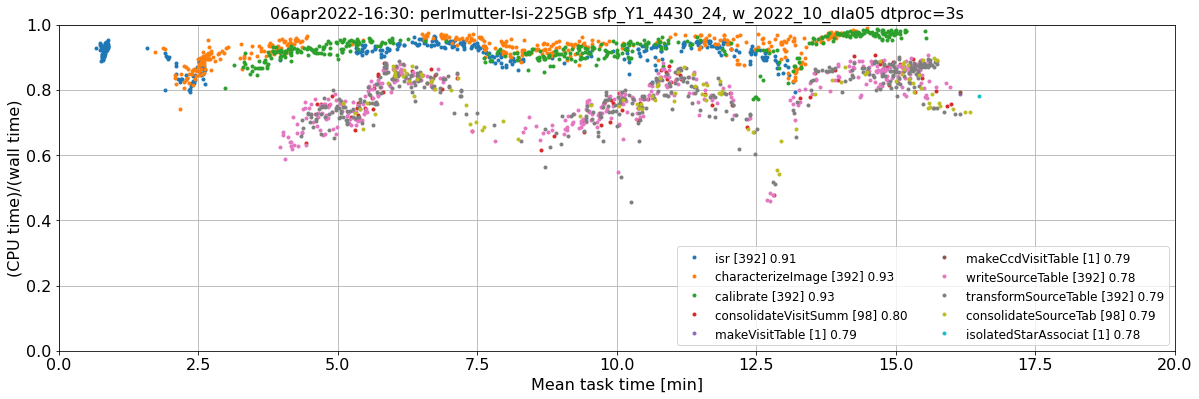

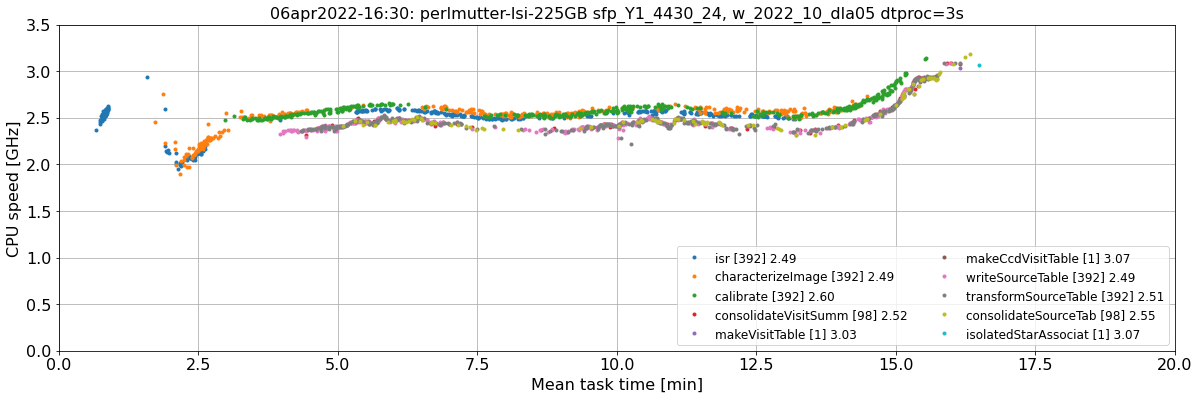

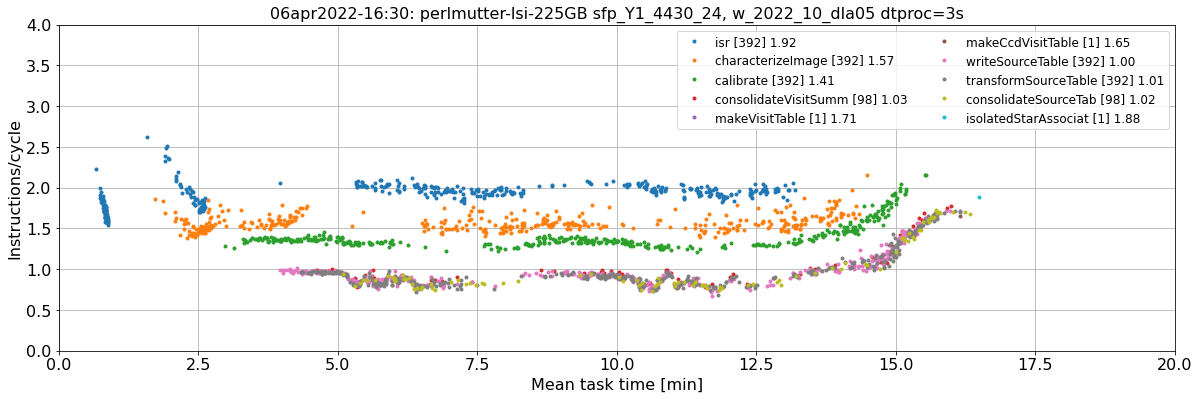

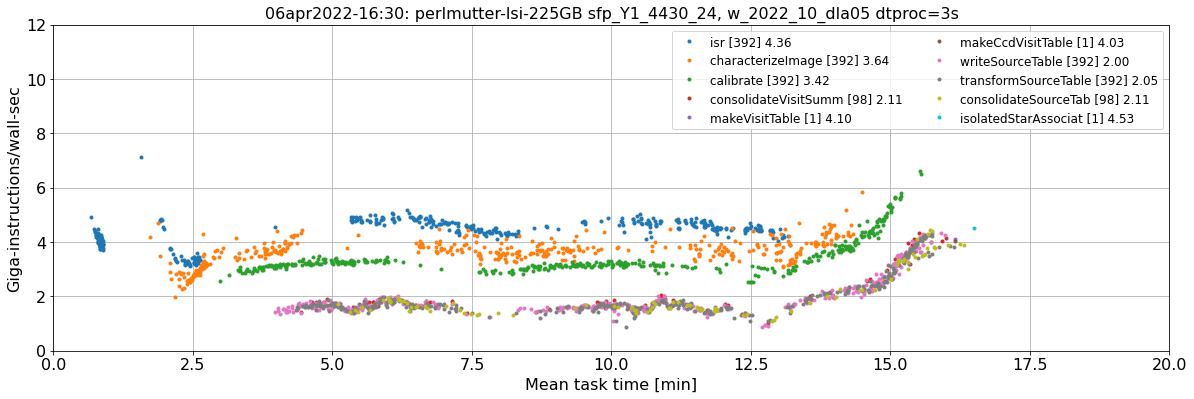

In [12]:
spfac = 1.0/1.e6
ntsk = max(pft.task_idx) + 1
tmeans = ntsk*[None]
cptefs = ntsk*[None]
speeds = ntsk*[None]
ipcs   = ntsk*[None]
ipws   = ntsk*[None]
slabs  = ntsk*[None]
for itsk in range(ntsk):
    slabs[itsk] = dbr.task_names[itsk][0:20]
    pfts = pft.query(f"task_idx=={itsk}")
    tmeans[itsk] = pfts.tmean
    cptefs[itsk] = pfts.cputeff
    speeds[itsk] = pfts.speed*spfac
    ipcs[itsk]   = pfts.ipc
    ipws[itsk]   = pfts.ipw
tplt1 = 0
tplt2 = tmean_max
slabx = 'Mean task time [min]'
multigraph(tmeans, cptefs, tplt1, tplt2, 0,   1, slabs, slabx, '(CPU time)/(wall time)',     sttl, 'tmean_cputeffs', 'lower right', 2)
multigraph(tmeans, speeds, tplt1, tplt2, 0, 3.5, slabs, slabx, 'CPU speed [GHz]',            sttl, 'tmean_speeds', 'lower right', 2)
multigraph(tmeans,   ipcs, tplt1, tplt2, 0,   4, slabs, slabx, 'Instructions/cycle',    sttl, 'tmean_ipcs', 'upper right', 2)
multigraph(tmeans,   ipws, tplt1, tplt2, 0,  12, slabs, slabx, 'Giga-instructions/wall-sec', sttl, 'tmean_ipws', 'upper right', 2)

## Running tasks vs. time

Saving plot to ptest17-time_ntask.png


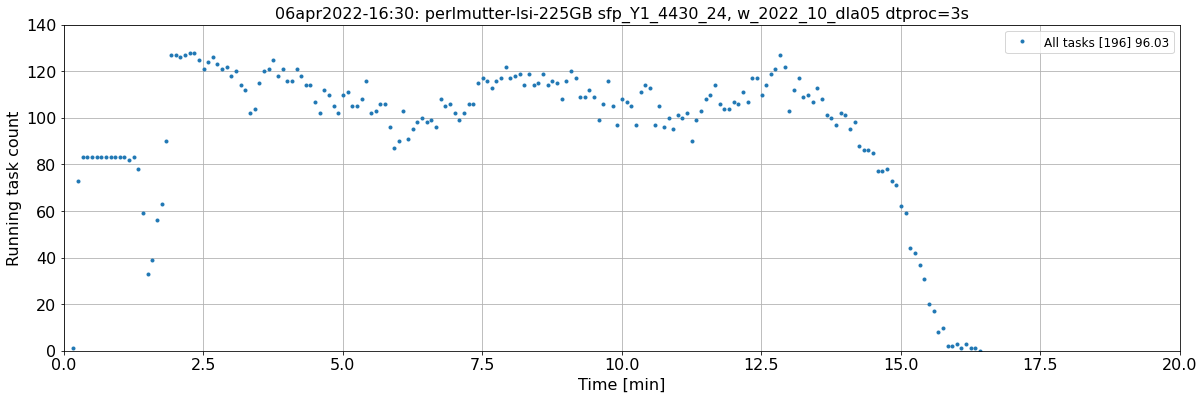

In [13]:
t1 = min(pft.tstart)
t2 = max(pft.tstop)
tstep = 5
nstep = int((t2 - t1)/tstep)
ran = range(nstep)
tval = pandas.Series(nstep*[None])
ntsks = pandas.Series(nstep*[None])
for istep in ran:
    tval[istep] = t1 + istep*tstep
    pftrun = pft.query(f"{tval[istep]}>=tstart and {tval[istep]}<tstop")
    ntsks[istep] = len(pftrun)
graph(tval/60, ntsks, tplt1, tplt2, 0, 140, 'All tasks', 'Time [min]', 'Running task count', sttl, 'time_ntask')    


In [14]:
dt = t2 - t1
dtmin = dt/60
ntsk = len(pft)
ngin = pft.gins.sum()
rtsk = ntsk/dtmin
rgin = ngin/dt
rtsk_ref = 115.4
rgin_ref = 298
ntc = ntsks.mean()
ntc_ref = 45.4
print(f" Task throughput:{rtsk:6.1f} tasks/minute           [{rtsk/rtsk_ref:.2f}]")
print(f"Inst. throughput:{rgin:6.1f} giga-instructions/sec  [{rgin/rgin_ref:.2f}]")
print(f"Mean running task count: {ntc:5.1f}                 [{ntc/ntc_ref:.2f}]")

 Task throughput: 131.7 tasks/minute           [1.14]
Inst. throughput: 340.4 giga-instructions/sec  [1.14]
Mean running task count:  96.0                 [2.12]


## System CPU speed vs time.

Saving plot to ptest17-time_syscpuspeed.png


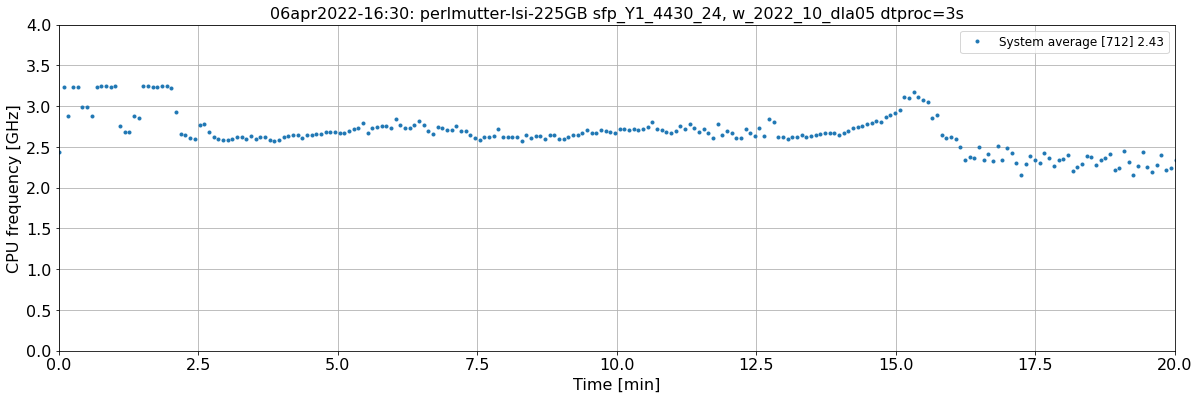

In [15]:
if sym is not None and 'cpu_freq' in sym.columns:
    graph(sym.tfix/60, sym.cpu_freq, tplt1, tplt2, 0, 4, 'System average', 'Time [min]', 'CPU frequency [GHz]', sttl, 'time_syscpuspeed')